# Class 10 - Responsible AI: Fairness

Auxiliar report to compute the confusion matrixes for all the instances and dividing by race

## Imports

In [14]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score,  roc_curve, auc

# Aequitas
from aequitas import Audit
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
import aequitas.plot as ap

np.random.seed(0)  # For reproducibility

## Load Data

In [15]:
data_url = 'https://raw.githubusercontent.com/Hospital-Da-Luz-Learning-Health/MLCatolica24/main/Aula%2010%20-%20%20Responsible%20AI/data_class10/Liver_disease.csv'
df = pd.read_csv(data_url)
df.shape

(1700, 11)

In [16]:
df['Diagnosis'].value_counts()

Diagnosis
1    936
0    764
Name: count, dtype: int64

## Creating synthetically a new feature

In [17]:
# Function to assign race based on Diagnosis
def assign_race(diagnosis):
    if diagnosis == 1:
        return np.random.choice(['White', 'Non-White'], p=[0.75, 0.25])
    else:
        return np.random.choice(['White', 'Non-White'], p=[0.5, 0.5])

In [18]:
# Apply the function to create the Race column
df['Race'] = df['Diagnosis'].apply(assign_race)

In [19]:
df[df['Diagnosis']==1]['Race'].value_counts()

Race
White        696
Non-White    240
Name: count, dtype: int64

In [20]:
df[df['Diagnosis']==0]['Race'].value_counts()

Race
Non-White    391
White        373
Name: count, dtype: int64

## Prepare data for model training

In [21]:
# Split data into features (X) and target (y)
X = df.drop(columns=['Diagnosis'])
y = df['Diagnosis']

In [22]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify= y, random_state=42)

In [23]:
# Standardize continuous variables (assuming continuous columns are 'Age', 'BMI', 'AlcoholConsumption', 'PhysicalActivity', 'LiverFunctionTest')
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

In [24]:
continuous_columns = ['Age', 'BMI', 'AlcoholConsumption', 'PhysicalActivity', 'LiverFunctionTest']
X_train_scaled[continuous_columns] = scaler.fit_transform(X_train[continuous_columns])
X_test_scaled[continuous_columns] = scaler.transform(X_test[continuous_columns])

In [25]:
# Encode categorical variables (Race)
X_train_scaled = pd.get_dummies(X_train_scaled, columns=['Race'], drop_first=True)
X_test_scaled = pd.get_dummies(X_test_scaled, columns=['Race'], drop_first=True)

X_train_scaled['Race_White'] = X_train_scaled['Race_White'].astype(int)
X_test_scaled['Race_White'] = X_test_scaled['Race_White'].astype(int)

In [26]:
X_train.head()

,Age,Gender,BMI,AlcoholConsumption,Smoking,GeneticRisk,PhysicalActivity,Diabetes,Hypertension,LiverFunctionTest,Race
427,40,1,20.388247,6.353894,0,1,2.624078,0,0,55.364857,White
647,77,1,15.167760,9.654269,1,0,4.132034,0,0,23.434892,Non-White
1152,75,0,24.054406,6.474617,0,0,5.021620,0,0,38.383655,White
206,70,0,27.404160,13.400651,0,0,4.176390,0,0,60.864391,White
1189,66,1,38.730216,15.664309,0,2,4.574616,0,0,71.785638,Non-White


In [27]:
X_train_scaled.head()

,Age,Gender,BMI,AlcoholConsumption,Smoking,GeneticRisk,PhysicalActivity,Diabetes,Hypertension,LiverFunctionTest,Race_White
427,-0.572980,1,-1.009209,-0.612218,0,1,-0.845307,0,0,-0.200288,1
647,1.515109,1,-1.734112,-0.035173,1,0,-0.315866,0,0,-1.599087,0
1152,1.402240,0,-0.500136,-0.591111,0,0,-0.003534,0,0,-0.944207,1
206,1.120066,0,-0.034998,0.619854,0,0,-0.300293,0,0,0.040638,1
1189,0.894326,1,1.537708,1.015638,0,2,-0.160476,0,0,0.519080,0


## Model Training and Evaluation

In [28]:
X_train_scaled = X_train_scaled.drop(columns=['Race_White'])
X_test_scaled = X_test_scaled.drop(columns=['Race_White'])

In [29]:
# Train a logistic regression model
model = LogisticRegression(class_weight='balanced')
model.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced')

In [30]:
# Predictions
y_pred = model.predict(X_test_scaled)

In [31]:
# Predictions
y_pred_prob = model.predict_proba(X_test_scaled)[:,1]

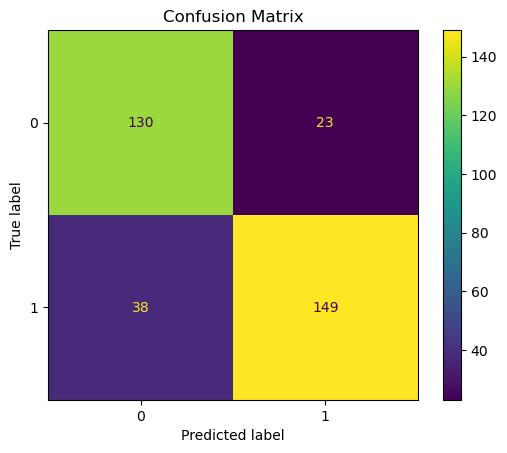

In [32]:
# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

## Fairness and Bias

### Thresholds analysis

In [33]:
# Create a empty dataframe
df = pd.DataFrame()

In [34]:
# Add probability score to the dataframe
df['score'] = y_pred_prob.tolist()

# Add true value for the label
df['label_value'] = y_test.tolist()

# Add sensitive attribute --> Race columns
df['Race'] = X_test['Race'].tolist()

In [37]:
# Sort by score
df = df.sort_values(by=['score'], ascending=False)

In [38]:
sampled_df_fraction = df.iloc[::20]
sampled_df_fraction

,score,label_value,Race
328,0.999800,1,White
249,0.986034,1,Non-White
29,0.965328,1,Non-White
58,0.927179,1,White
0,0.889940,0,White
62,0.837430,1,White
16,0.773571,1,White
38,0.690866,1,Non-White
87,0.590255,1,White
40,0.468367,0,White


In [39]:
# Function to calculate, plot the confusion matrix, and compute TPR and FPR for a given threshold
def plot_confusion_matrix_and_rates(df, threshold, fontsize=15, labelsize=15):
    df['predicted'] = (df['score'] >= threshold).astype(int)
    cm = confusion_matrix(df['label_value'], df['predicted'])
    tn, fp, fn, tp = cm.ravel()
    
    # Calculate TPR and FPR
    tpr = tp / (tp + fn) if (tp + fn) != 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
    
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot()
    plt.title(f'Confusion Matrix for threshold {threshold}', fontsize=labelsize)
    
    # Increase font size of numbers in the confusion matrix
    for texts in disp.ax_.texts:
        texts.set_fontsize(fontsize)
    
    # Increase font size of axis labels
    disp.ax_.set_xlabel('Predicted Label', fontsize=labelsize)
    disp.ax_.set_ylabel('True Label', fontsize=labelsize)
    
    # Increase font size of tick labels
    disp.ax_.tick_params(axis='both', which='major', labelsize=labelsize)
    
    plt.show()
    
    print(f'For threshold {threshold}:')
    print(f'True Positive Rate (TPR): {tpr:.2f}')
    print(f'False Positive Rate (FPR): {fpr:.2f}\n')

/tmp/ipykernel_58497/2130037438.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted'] = (df['score'] >= threshold).astype(int)


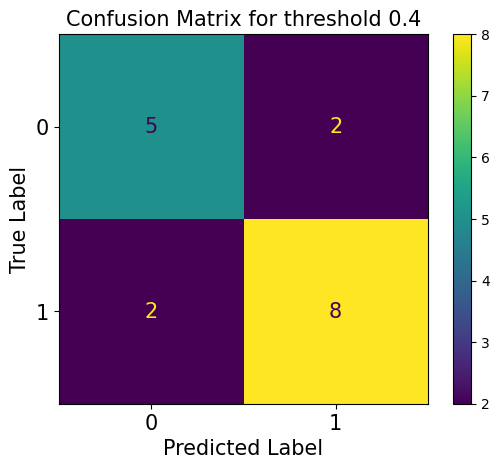

For threshold 0.4:
True Positive Rate (TPR): 0.80
False Positive Rate (FPR): 0.29



In [40]:
# Thresholds to evaluate
thresholds = [0.4]

# Calculate and plot confusion matrices for each threshold
for threshold in thresholds:
    plot_confusion_matrix_and_rates(sampled_df_fraction, threshold)

In [41]:
# Function to calculate, plot the confusion matrix, and compute TPR and FPR for a given threshold and race
def plot_confusion_matrix_and_rates(df, threshold, race, fontsize=15, labelsize=15):
    df_race = df[df['Race'] == race]
    df_race['predicted'] = (df_race['score'] >= threshold).astype(int)
    cm = confusion_matrix(df_race['label_value'], df_race['predicted'])
    tn, fp, fn, tp = cm.ravel()
    
    # Calculate TPR and FPR
    tpr = tp / (tp + fn) if (tp + fn) != 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
    
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot()
    plt.title(f'Confusion Matrix for {race} (threshold {threshold})', fontsize=labelsize)
    
    # Increase font size of numbers in the confusion matrix
    for texts in disp.ax_.texts:
        texts.set_fontsize(fontsize)
    
    # Increase font size of axis labels
    disp.ax_.set_xlabel('Predicted Label', fontsize=labelsize)
    disp.ax_.set_ylabel('True Label', fontsize=labelsize)
    
    # Increase font size of tick labels
    disp.ax_.tick_params(axis='both', which='major', labelsize=labelsize)
    
    plt.show()
    
    print(f'For {race} and threshold {threshold}:')
    print(f'True Positive Rate (TPR): {tpr:.2f}')
    print(f'False Positive Rate (FPR): {fpr:.2f}\n')

/tmp/ipykernel_58497/1214263685.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_race['predicted'] = (df_race['score'] >= threshold).astype(int)


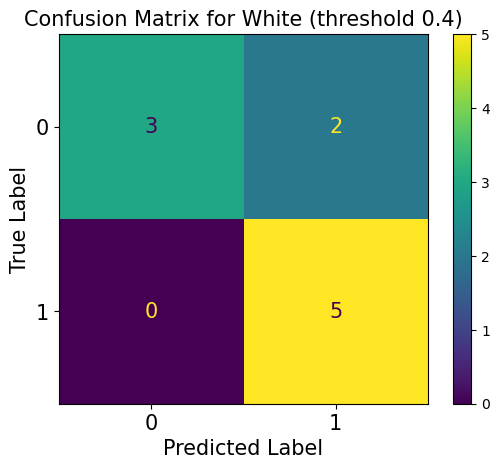

/tmp/ipykernel_58497/1214263685.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_race['predicted'] = (df_race['score'] >= threshold).astype(int)


For White and threshold 0.4:
True Positive Rate (TPR): 1.00
False Positive Rate (FPR): 0.40



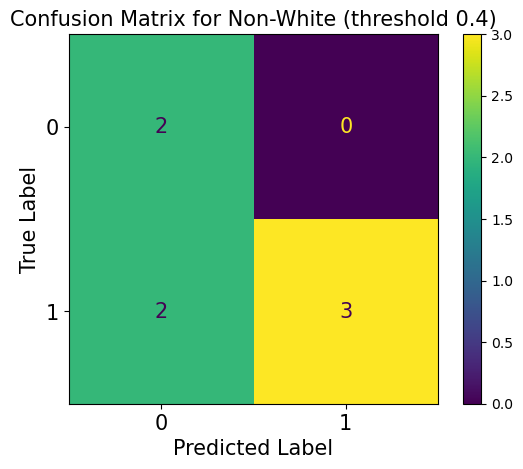

For Non-White and threshold 0.4:
True Positive Rate (TPR): 0.60
False Positive Rate (FPR): 0.00



In [42]:
# Thresholds to evaluate
thresholds = [0.4]

# Races to evaluate
races = df['Race'].unique()

# Calculate, plot confusion matrices, and compute TPR and FPR for each threshold and race
for race in races:
    for threshold in thresholds:
        plot_confusion_matrix_and_rates(sampled_df_fraction, threshold, race)